Max transmitted amplitude:  1.0457341420203068 V
Max transmitted power:  10.38842574934131 dBm


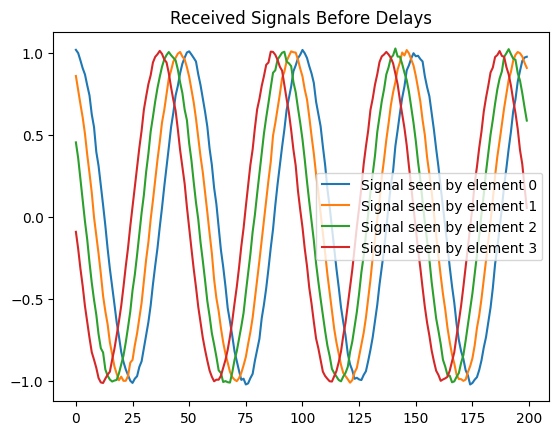

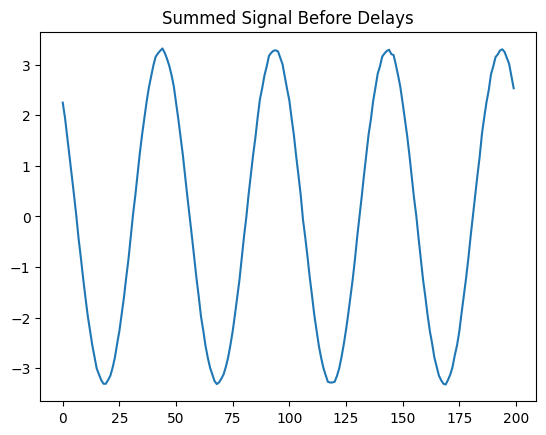

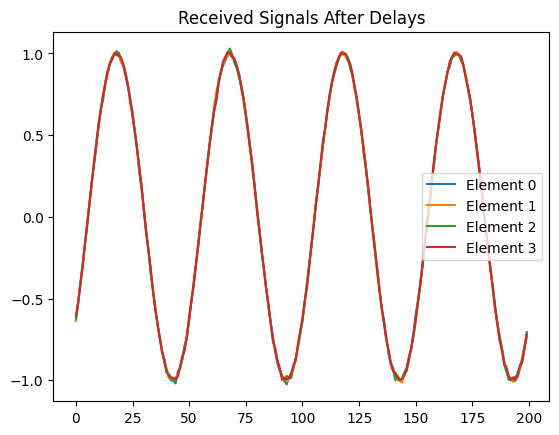

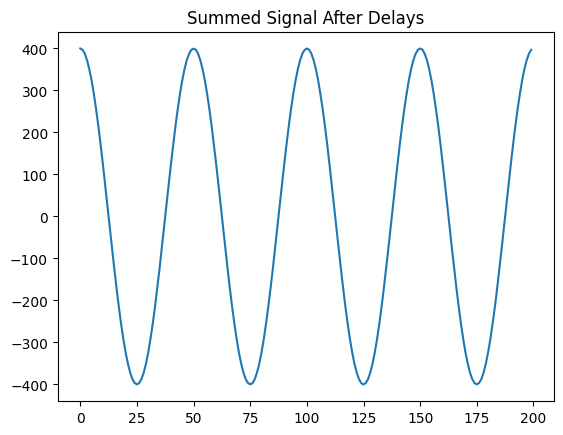

Max received amplitude:  400.4922789537743 V
Average received power:  62.05188295571634 dBm
Gain due to beamforming: 51.66345720637502 dB


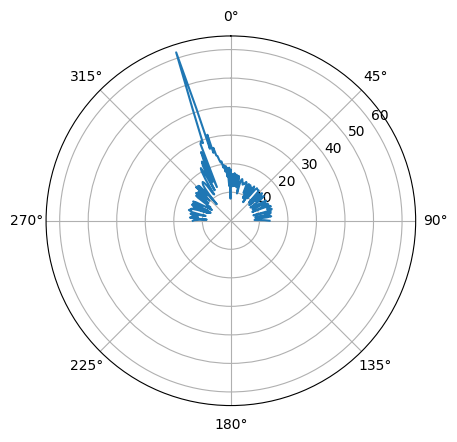

Detected angle: -10 degrees
Steering angle: -10 degrees
Average power at detected angle: 62.05188295571634 dBm
Average power at steering angle: 62.05188295571634 dBm
Detected angle and steering angle differ by 0 degree(s).
Left lobe detected angle: -25 degrees
Right lobe detected angle: 88 degrees
Left null detected angle: -35 degrees
Right null detected angle: 9 degrees


In [19]:
# Use this script to simulate expected radiation patterns of linear arrays based on different input parameters

import numpy as np
import matplotlib.pyplot as plt


sample_rate = 1e6 # sample rate in Hz
N = 10000 # number of samples to simulate
d = 0.5 # spacing of elements (.5 is half-wavelength)
Nr = 400 # number of elements
theta_degrees = -10 # direction of arrival in degrees
theta = theta_degrees / 180 * np.pi # convert to radians

# Create 4 tones to simulate signals being seen by each element
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6 # frequency of signal
signal = np.exp(2j * np.pi * f_tone * t)

# Calculate beamforming weights using angle of arrival (theta) and element spacing (d)
b = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # expressing beamforming weights as matrix

# Induce delay between the 4 received signals
tx = []
for element in range(0,Nr):
    tx.append(signal * b[element])

# Introduce noise
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
noise_factor = .01 # change to add or subtract noise
tx = tx + noise_factor*n # add noise

# Find max amplitude of each transmitted signal
max_amplitude = []
for i in range(0, len(tx)):
    max_amplitude.append(np.asarray(tx[i]).squeeze().real[np.argmax(np.asarray(tx[i]).squeeze().real)])

# Find overall max amplitude and calculate overall max power
max_transmitted_amplitude = max_amplitude[np.argmax(max_amplitude)]
print("Max transmitted amplitude: ", max_transmitted_amplitude, "V")
average_transmitted_power = 10*np.log10((((np.square(max_transmitted_amplitude/np.sqrt(2)))/50))/.001)
print("Max transmitted power: ", average_transmitted_power, "dBm")

# Plot signals seen by each individual element
plt.plot(np.asarray(tx[0]).squeeze().real[0:200], label="Signal seen by element 0")
plt.plot(np.asarray(tx[1]).squeeze().real[0:200], label="Signal seen by element 1")
plt.plot(np.asarray(tx[2]).squeeze().real[0:200], label="Signal seen by element 2")
plt.plot(np.asarray(tx[3]).squeeze().real[0:200], label="Signal seen by element 3")
plt.title("Received Signals Before Delays")
plt.legend()
plt.show()

# Plot summation of signals before beamforming weights applied
unbeamformed_signal = np.asarray(tx[0]).squeeze().real[0:200] + np.asarray(tx[1]).squeeze().real[0:200] + np.asarray(tx[2]).squeeze().real[0:200] + np.asarray(tx[3]).squeeze().real[0:200]
plt.plot(unbeamformed_signal, label="Summed")
plt.title("Summed Signal Before Delays")
plt.show()

# Multiply received signal data by beamforming weights
rx = []
for element in range(0,Nr):
    rx.append(b[Nr-1-element] * tx[element])

# Plot signal data after beamforming weights applied
plt.plot(np.asarray(rx[0]).squeeze().real[0:200], label="Element 0")
plt.plot(np.asarray(rx[1]).squeeze().real[0:200], label="Element 1")
plt.plot(np.asarray(rx[2]).squeeze().real[0:200], label="Element 2")
plt.plot(np.asarray(rx[3]).squeeze().real[0:200], label="Element 3")
plt.title("Received Signals After Delays")
plt.legend()
plt.show()

b = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # expressing beamforming weights as matrix
summed_signal = b.conj().T @ tx # perform beamforming matrix math method

# Plot summed signal after beamforming weights
summed_signal = np.asarray(summed_signal).squeeze().real
plt.plot(summed_signal[0:200], label="Summed")
plt.title("Summed Signal After Delays")
plt.show()

# Find overall max amplitude and calculate overall max power
max_received_amplitude = summed_signal[np.argmax(summed_signal)]
print("Max received amplitude: ", max_received_amplitude, "V")
average_received_power = 10*np.log10((np.square(max_received_amplitude/np.sqrt(2))/50)/.001)
print("Average received power: ", average_received_power, "dBm") 
print("Gain due to beamforming:", 20*np.log10(max_received_amplitude/max_transmitted_amplitude), "dB")

# Measure power at certain number of steps between -90 and 90 degrees off of broadside
number_measurements = 201
theta_scan_rad = np.linspace(-np.pi/2, np.pi/2, number_measurements) # used for polar plot
theta_scan = list(range(-90, -90+number_measurements)) # used for iteration
results = []
for theta_i in theta_scan:
   theta_rad = theta_i / 180 * np.pi # convert to radians
   w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_rad)) # calculate weights
   r_weighted = w.conj().T @ tx # apply weights
   results.append(10*np.log10((np.square(np.asarray(r_weighted).squeeze().real[np.argmax(np.asarray(r_weighted).squeeze().real)]/np.sqrt(2))/50)/.001)) # calculate max power at current angle

# Get stats
detected_angle = theta_scan[np.argmax(results)] # steering angle should be where max power occurred
left_lobe_angle = theta_scan[np.argmax(results[0:66])]
right_lobe_angle = theta_scan[np.argmax(results[121:181])+121]
left_null_angle = theta_scan[np.argmin(results[30:90])+30]
right_null_angle = theta_scan[np.argmin(results[90:150])+90]

# Plot on polar graph
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_scan_rad, results) # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
plt.show()

# Print stats
print("Detected angle:", detected_angle, "degrees")
print("Steering angle:", theta_degrees, "degrees")
print("Average power at detected angle:", results[np.argmax(results)], "dBm")
print("Average power at steering angle:", results[theta_degrees+90], "dBm")
print("Detected angle and steering angle differ by", abs(theta_degrees-detected_angle), "degree(s).")
print("Left lobe detected angle:", left_lobe_angle, "degrees")
print("Right lobe detected angle:", right_lobe_angle, "degrees")
print("Left null detected angle:", left_null_angle, "degrees")
print("Right null detected angle:", right_null_angle, "degrees")
